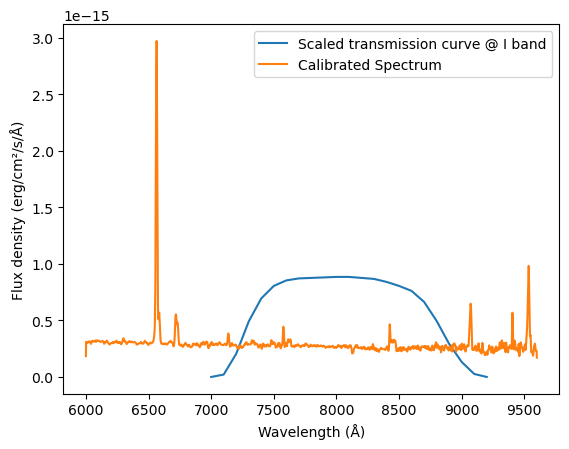

In [11]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pyetc import *
import os

def calibrate_spectrum(wave_spec, flux_spec, filter_file, mag_AB):
    """
    Calibrates a relative spectrum to physical units (erg/cm^2/s/Å) using an AB magnitude in a given filter.

    Parameters:
    - wave_spec : array-like, Wavelength of the spectrum [Å]
    - flux_spec : array-like, Relative flux of the spectrum
    - filter_file : str, Path to the filter transmission file (two columns: wavelength, transmission)
    - mag_AB : float, Known AB magnitude in the given filter

    Returns:
    - wave_spec : array-like, Wavelengths of the calibrated spectrum [Å]
    - flux_calibrated : array-like, Calibrated flux in erg/cm^2/s/Å
    - wave_filt : array-like, Wavelengths of the transmission curve [Å]
    - trans_filt : array-like, Transmission curve, dimensionless
    """

    # Load filter data from file (assumes two columns: wavelength [Å] and transmission [dimensionless])
    wave_filt, trans_filt = np.loadtxt(filter_file, unpack=True)

    # Check if the filter is within the spectrum range
    if wave_filt.min() < wave_spec.min() or wave_filt.max() > wave_spec.max():
        print("The filter is outside the spectrum range, calibration not possible.")
        return None, None

    # Interpolate spectrum flux to the filter wavelength grid
    interp_flux = interp1d(wave_spec, flux_spec, kind='linear', bounds_error=False, fill_value=0)
    flux_interp = interp_flux(wave_filt)

    # Compute synthetic magnitude (AB system)
    num = np.trapz(flux_interp * trans_filt, wave_filt)   # Integral of F_lambda * T_lambda
    den = np.trapz(trans_filt, wave_filt)                 # Integral of T_lambda
    f_nu = 10**(-0.4 * (mag_AB + 48.6))                   # Convert mag_AB to f_nu (erg/cm^2/s/Hz)

    # Compute flux scaling factor
    c = 2.99792458e18  # Speed of light in Å/s
    f_lambda_AB = f_nu * (c / (wave_filt**2))  # Convert f_nu to f_lambda
    scale_factor = np.trapz(f_lambda_AB * trans_filt, wave_filt) / num

    # Apply the scaling factor to the entire spectrum
    flux_calibrated = flux_spec * scale_factor
    
    # Return the calibrated spectrum and the filter curve
    return wave_spec, flux_calibrated, wave_filt, trans_filt


mag = 17.0
syst = 'AB'
filt = "I"
filter_file = f"filters/{filt}.dat"

# Vega to AB conversion factors
vega_to_ab = {
    "U": 0.87, "B": 0.12, "V": 0.03, "R": 0.21, "I": 0.45, "J": 0.91, 
    "H": 1.39, "K": 1.85, "u": 0.88, "g": 0.10, "r": 0.10, "i": 0.12, "z": 0.23
}

if syst == 'Vega':
    mag += vega_to_ab.get(filt, 0)
elif syst != 'AB':
    raise ValueError("Magnitude system not recognized")

# Spectrum data 
#IN THIS EXAMPLE ARE COMPUTED FROM THE MPDAF SPECTRUM OBJECT FOR A GIVEN CONFIGURATION OF INST+CHANNEL
#but you can just pass two arrays in wave (Angstrom) and dimensionless of whatever relative intensity

''''''
obj_WST = WST(log = 'DEBUG', skip_dataload = False)
CONF = obj_WST.ifs['red']
wave = 8500 #just set this to a random wavelength, 
#the important thing is that this should be inside the range of CONF
dw = 50 #default random value
dspec = dict(type='template', name='kc96/starb1', redshift=0., wave_center=wave, wave_width=dw)
spec = obj_WST.get_spec(CONF, dspec, oversamp=10, lsfconv=True)


wave_spec = np.array(spec.wave.coord())
flux_spec = np.array(spec.data)       

wave_cal, flux_cal, wave_filt, trans_filt = calibrate_spectrum(wave_spec, flux_spec, filter_file, mag)

#Plot to check if the calibration went well 
if wave_cal is not None:
    #change as you like the factor on trans_filt to see the transmission curve properly on the plot
    plt.plot(wave_filt, trans_filt*3*np.mean(flux_cal), label=f'Scaled transmission curve @ {filt} band')
    plt.plot(wave_cal, flux_cal, label='Calibrated Spectrum')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux density (erg/cm²/s/Å)')
    plt.legend()
    plt.show()


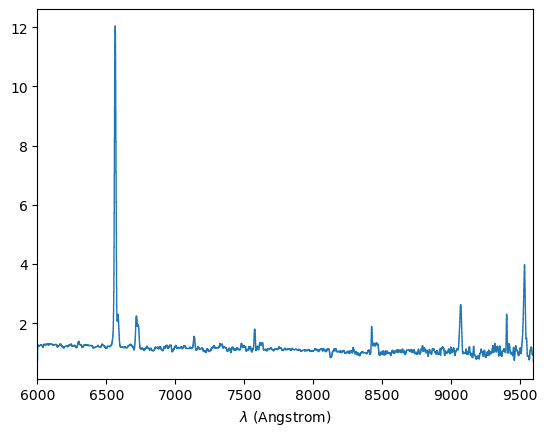

In [12]:
#To see the original spectrum
spec.plot()